In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
import warnings
warnings.filterwarnings("ignore")

In [2]:
import requests
import pandas as pd

# Define the URL for the API
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"

# Define the SQL query to retrieve the required data
query = """
SELECT 
    pl_name, 
    hostname, 
    default_flag,
    pl_orbsmax, 
    pl_orbsmaxerr1, 
    pl_orbsmaxerr2, 
    pl_rade,
    pl_radeerr1,
    pl_radeerr2,
    pl_bmasse, 
    pl_bmasseerr1, 
    pl_bmasseerr2, 
    sy_pnum, 
    pl_orbeccen, 
    pl_orbeccenerr1, 
    pl_orbeccenerr2, 
    pl_orbincl, 
    pl_orbinclerr1, 
    pl_orbinclerr2,
    pl_trueobliq,
    pl_trueobliqerr1,
    pl_trueobliqerr2
FROM ps
WHERE 
    sy_pnum > 1
"""
# we used to have default_flag = 1 AND sy_snum = 1

# Define the parameters for the request
params = {
    "query": query,
    "format": "json",
}

# Make the request to the API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Convert the JSON data to a pandas DataFrame
    df_query = pd.DataFrame(data)
    
    # Display the DataFrame
    # print(df)
else:
    print(f"Error: {response.status_code}")

In [3]:
df = df_query.copy()

In [4]:
df[df["pl_trueobliq"].notnull()][["pl_name", "pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"]]

,pl_name,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2
279,K2-290 c,124.00,6.00,-6.00
371,HAT-P-11 b,106.00,15.00,-11.00
471,XO-2 N b,27.00,12.00,-27.00
654,WASP-107 b,109.81,28.17,-13.64
665,V1298 Tau b,8.00,4.00,-7.00
668,Kepler-9 b,28.10,13.00,-13.60
803,WASP-84 b,17.30,7.70,-7.70
2512,Kepler-25 c,26.90,7.00,-9.20
3805,TOI-942 b,2.00,27.00,-23.00
4462,Kepler-462 b,72.00,3.00,-3.00


In [5]:
drop_indices = []

for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]
    # we check the names of the planets in the system
    # if they use a different naming convention, we discard the system
    names = df_host["pl_name"]
    # check if the first three characters are the same
    if len(set([name[:3] for name in names])) > 1:
        # discard the system
        print(f"Discarding {hostname}")
        drop_indices.extend(df_host.index)

df.drop(df.index[drop_indices], inplace=True)
# Later we can do something more sophisticated to match the names

Discarding GJ 143
Discarding HD 39091
Discarding KOI-12
Discarding HIP 8541
Discarding HD 22946
Discarding KOI-351
Discarding KOI-142
Discarding 14 Her
Discarding Kepler-324
Discarding K2-168
Discarding KOI-7892
Discarding GJ 411
Discarding HD 80653
Discarding KIC 5437945
Discarding 2MASS J19383260+4603591
Discarding K2-166
Discarding K2-282
Discarding K2-16
Discarding KIC 9663113
Discarding K2-50
Discarding Kepler-968


In [6]:
keep_indices = []

for planet in df["pl_name"].unique():
    df_planet = df[df["pl_name"] == planet]
    # we average the parameters for each planet in the system
    # so there will be for instance 2 rows correpsonding to the same planet
    # and we will have the average of the parameters
    default_index = df_planet[df_planet["default_flag"] == 1].index
    # print(f"Processing {planet}, default indices: {default_index}")
    for col in df_planet.columns[3:]:
        # take the average of the values (ignoring NaNs)
        avg = np.nanmedian(df_planet[col].values)
        # overwrite the values in the original df where default_flag = 1
        # print(f"Overwriting {col} for {planet} with {avg}")
        df.loc[default_index, col] = avg
    keep_indices.extend(default_index)

df.drop(df.index[~df.index.isin(keep_indices)], inplace=True)

In [7]:
# FLAGS:
# flag = 0 (default): all values present from the retrieved data
# flag = 01: we assume eccentricity of the planet from the e-N anti-correlation
# flag = 02: we assume mass of the planet using mass-radius relation (spright)
# flag = 03: we assume inclination of the missing planets are coplanar wrt the most massive planet in the system
# flag = 04: we fill the errorbars of the semi-major axis of the missing planets
# flag = 012: mix of 1 and 2
# flag = 013: mix of 1 and 3
# flag = 023: mix of 2 and 3
# flag = 0123: mix of 1, 2 and 3

In [8]:
df["flag"] = "0"

Fill in the missing values in eccentricity

In [9]:
# select rows where the pl_orbeccen is nan
eccnan_index = df[df['pl_orbeccen'].isnull()].index
df.loc[eccnan_index, 'pl_orbeccen'] = 0.63 * df.loc[eccnan_index, 'sy_pnum']**(-1.02)
df.loc[eccnan_index, 'pl_orbeccenerr1'] = 0.0
df.loc[eccnan_index, 'pl_orbeccenerr2'] = 0.0
df.loc[eccnan_index, 'flag'] += "1"

# select rows where the pl_orbeccenerr1 is nan
eccerr1nan_index = df[df['pl_orbeccenerr1'].isnull()].index
df.loc[eccerr1nan_index, 'pl_orbeccenerr1'] = 0.0
df.loc[eccerr1nan_index, 'flag'] += "1+"

# select rows where the pl_orbeccenerr2 is nan
eccerr2nan_index = df[df['pl_orbeccenerr2'].isnull()].index
df.loc[eccerr2nan_index, 'pl_orbeccenerr2'] = 0.0
df.loc[eccerr2nan_index, 'flag'] += "1-"

Fill in the missing values in mass

In [10]:
from spright import RMRelation
rmr = RMRelation()

plmassnan_index = df[
    df['pl_bmasse'].isnull() & 
    (df['pl_rade'] > 0.5) & 
    (df['pl_rade'] < 6.0) & 
    (
        ~df['pl_radeerr1'].isnull() & 
        ~df['pl_radeerr2'].isnull()
        )
        ].index

df.loc[plmassnan_index, 'flag'] += "2"

In [11]:
for n, idx in enumerate(plmassnan_index):
    # if n % 100 == 0:
    #     print(idx)
    mds = rmr.predict_mass(
        radius=(
            df.loc[idx, 'pl_rade'], 
            0.5 * (df.loc[idx, 'pl_radeerr1'] - df.loc[idx, 'pl_radeerr2']))
        )
    q16, q50, q84 = np.percentile(mds.samples, [16, 50, 84])
    df.loc[idx, 'pl_bmasse'] = q50
    df.loc[idx, 'pl_bmasseerr1'] = q84 - q50
    df.loc[idx, 'pl_bmasseerr2'] = q16 - q50

In [12]:
# remove systems where at least one planet has no mass
for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]
    if df_host["pl_bmasse"].isnull().any():
        print(f"Removing {hostname}")
        df = df.drop(df_host.index)

Removing Kepler-397
Removing HIP 41378
Removing TOI-1634
Removing Kepler-444
Removing Kepler-511
Removing Kepler-1085
Removing Kepler-297
Removing Kepler-487
Removing Kepler-799
Removing Kepler-1311
Removing Kepler-603
Removing Kepler-730
Removing LkCa 15
Removing Kepler-141
Removing KIC 10001893
Removing Kepler-118
Removing Kepler-561
Removing Kepler-302
Removing Kepler-108
Removing Kepler-148


In [13]:
# select rows where the pl_bmasserr1 is nan
masserr1nan_index = df[df['pl_bmasseerr1'].isnull()].index
df.loc[masserr1nan_index, 'pl_bmasseerr1'] = 0.0
df.loc[masserr1nan_index, 'flag'] += "2+"

# select rows where the pl_bmasserr2 is nan
masserr2nan_index = df[df['pl_bmasseerr2'].isnull()].index
df.loc[masserr2nan_index, 'pl_bmasseerr2'] = 0.0
df.loc[masserr2nan_index, 'flag'] += "2-"

In [14]:
# get rid of columns with rade
df = df.drop(columns=["pl_rade", "pl_radeerr1", "pl_radeerr2"])

In [15]:
df[df["hostname"] == "7 CMa"]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag
4646,7 CMa b,7 CMa,1,1.900,0.024,-0.01,781.8618,44.4962,-44.4962,2,0.14,0.06,-0.06,90.0,NaN,NaN,NaN,NaN,NaN,0
4674,7 CMa c,7 CMa,1,2.153,0.003,-0.08,276.5121,19.0698,-19.0698,2,0.08,0.05,-0.04,90.0,NaN,NaN,NaN,NaN,NaN,0


Fill in the missing values in inclination

In [16]:
# input missing inclinations
for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]

    inclnan_index = df_host[df_host['pl_orbincl'].isnull()].index
    inclerr1nan_index = df_host[df_host['pl_orbinclerr1'].isnull()].index
    inclerr2nan_index = df_host[df_host['pl_orbinclerr2'].isnull()].index

    sytem_multiplicity = df_host["sy_pnum"].max()
    # maxmass_pl = df_host["pl_bmasse"].idxmax()  # this is deprecated by pandas
    maxmass_pl = df_host["pl_bmasse"].max()
    maxmass_pl = df_host[df_host["pl_bmasse"] == maxmass_pl].index[0]

    # if none of the inclinations are nan, check that the errors are not nan
    # and if they are, set them to 0
    if len(inclnan_index) == 0:
        if len(inclerr1nan_index) > 0:
            df.loc[inclerr1nan_index, 'pl_orbinclerr1'] = 0.0
            df.loc[inclerr1nan_index, 'flag'] += "3+"
        if len(inclerr2nan_index) > 0:
            df.loc[inclerr2nan_index, 'pl_orbinclerr2'] = 0.0
            df.loc[inclerr2nan_index, 'flag'] += "3-"

    # if all the inclinations are nan, set them to 90
    elif len(inclnan_index) == sytem_multiplicity:
        df.loc[inclnan_index, 'pl_orbincl'] = 90.0
        df.loc[inclnan_index, 'pl_orbinclerr1'] = 0.0
        df.loc[inclnan_index, 'pl_orbinclerr2'] = 0.0
        df.loc[inclnan_index, 'flag'] += "3"

    # if the most massive planet has inclination nan, set all the inclinations to 90
    ### we can consider changing this to the next most massive planet later on ###
    elif maxmass_pl in inclnan_index:
        df.loc[inclnan_index, 'pl_orbincl'] = 90.0
        df.loc[inclnan_index, 'pl_orbinclerr1'] = 0.0
        df.loc[inclnan_index, 'pl_orbinclerr2'] = 0.0
        df.loc[inclnan_index, 'flag'] += "3"

    # if any planet other than the most massive planet has inclination nan, set them to the inclination of the most massive planet
    else:
        for idx in inclnan_index:
            df.loc[idx, 'pl_orbincl'] = df.loc[maxmass_pl, 'pl_orbincl']
            df.loc[idx, 'pl_orbinclerr1'] = df.loc[maxmass_pl, 'pl_orbinclerr1']
            df.loc[idx, 'pl_orbinclerr2'] = df.loc[maxmass_pl, 'pl_orbinclerr2']
            df.loc[idx, 'flag'] += "3"
    

Fill in the missing values in semimajor axis

In [17]:
# select rows where the pl_orbsmax is not nan but the errors are nan
smaxnan_index = df[df['pl_orbsmax'].notnull() & df['pl_orbsmaxerr1'].isnull() & df['pl_orbsmaxerr2'].isnull()].index
df.loc[smaxnan_index, 'pl_orbsmaxerr1'] = 0.0
df.loc[smaxnan_index, 'pl_orbsmaxerr2'] = 0.0

In [18]:
df.to_csv("data.csv")

Load from here ->

In [55]:
df = pd.read_csv("data.csv")

In [56]:
df.index = df["Unnamed: 0"].values
# drop the Unnamed: 0 column
df = df.drop(columns=["Unnamed: 0"])

In [57]:
df[df["pl_trueobliq"].notnull()][["pl_name", "pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"]]

,pl_name,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2
192,WASP-84 b,17.30,7.70,-7.70
479,XO-2 N b,27.00,12.00,-27.00
1179,HAT-P-11 b,106.00,15.00,-11.00
1312,K2-290 c,124.00,6.00,-6.00
1813,V1298 Tau b,8.00,4.00,-7.00
1884,Kepler-9 b,28.10,13.00,-13.60
1911,WASP-107 b,109.81,28.17,-13.64
3192,Kepler-462 b,72.00,3.00,-3.00
3805,TOI-942 b,2.00,27.00,-23.00
4277,Kepler-25 c,26.90,7.00,-9.20


In [58]:
df[df["pl_trueobliq"].notnull()]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag
192,WASP-84 b,WASP-84,1,0.07730,0.00145,-0.00145,220.282500,13.03103,-12.713200,2,0.000,0.00000,0.00000,88.3680,0.0500,-0.0500,17.30,7.70,-7.70,01+1-
479,XO-2 N b,XO-2 N,1,0.03673,0.00064,-0.00064,184.182485,10.48839,-12.553875,3,0.006,0.03800,-0.02200,88.0100,0.5100,-0.5450,27.00,12.00,-27.00,0
1179,HAT-P-11 b,HAT-P-11,1,0.05300,0.00062,-0.00066,25.743000,2.76512,-2.765120,2,0.099,0.05000,-0.05000,89.8200,0.6000,-0.6000,106.00,15.00,-11.00,0
1312,K2-290 c,K2-290,1,0.30500,0.01700,-0.01700,246.000420,14.93801,-14.938010,2,0.000,0.00000,0.00000,89.3700,0.0800,-0.0700,124.00,6.00,-6.00,01+1-
1813,V1298 Tau b,V1298 Tau,1,0.16880,0.00260,-0.00260,203.410180,60.38740,-60.387400,4,0.134,0.10400,-0.07900,88.8795,0.4100,-0.2400,8.00,4.00,-7.00,0
1884,Kepler-9 b,Kepler-9,1,0.14230,0.00400,-0.00350,43.541000,2.70000,-3.300000,3,0.000,0.00100,-0.00130,89.3800,0.1335,-0.1325,28.10,13.00,-13.60,0
1911,WASP-107 b,WASP-107,1,0.05530,0.00130,-0.00130,37.980685,3.17830,-3.178300,2,0.000,0.04000,-0.04000,89.6300,0.1400,-0.1400,109.81,28.17,-13.64,0
3192,Kepler-462 b,Kepler-462,1,0.47310,0.00000,0.00000,53.900000,104.60000,-23.800000,2,0.000,0.03250,-0.01350,89.9500,0.0500,-0.0500,72.00,3.00,-3.00,0
3805,TOI-942 b,TOI-942,1,0.04866,0.00070,-0.00065,421.179000,0.00000,0.000000,2,0.285,0.11650,-0.11950,89.9660,0.3400,-0.5100,2.00,27.00,-23.00,02+2-
4277,Kepler-25 c,Kepler-25,1,0.11300,0.00000,0.00000,24.065460,3.36591,-3.265910,3,0.000,0.03745,-0.00705,89.9500,0.0420,-0.0390,26.90,7.00,-9.20,0


In [59]:
add_index = df.index.max() + 1
df.loc[add_index, 'pl_name'] = 'K2-290 b'
df.loc[add_index, 'hostname'] = 'K2-290'
df.loc[add_index, 'default_flag'] = 1

import astropy.units as u
df.loc[add_index, 'pl_orbsmax'] = 0.0923
df.loc[add_index, 'pl_orbsmaxerr1'] = 0.0
df.loc[add_index, 'pl_orbsmaxerr2'] = 0.0

df.loc[add_index, 'pl_orbincl'] = 88.2
df.loc[add_index, 'pl_orbinclerr1'] = 0.5
df.loc[add_index, 'pl_orbinclerr2'] = -0.6

df.loc[add_index, 'pl_bmasse'] = 10.9041861
df.loc[add_index, 'pl_bmasseerr1'] = 0.0
df.loc[add_index, 'pl_bmasseerr2'] = 0.0

df.loc[add_index, 'pl_trueobliq'] = 127.0
df.loc[add_index, 'pl_trueobliqerr1'] = 0.0
df.loc[add_index, 'pl_trueobliqerr2'] = 0.0

df.loc[add_index, 'sy_pnum'] = 2
df.loc[add_index, 'pl_orbeccen'] = 0.0
df.loc[add_index, 'pl_orbeccenerr1'] = 0.0
df.loc[add_index, 'pl_orbeccenerr2'] = 0.0

df.loc[add_index, 'flag'] = "0"

In [60]:
df[df["pl_trueobliq"].notnull()][["pl_name", "pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"]]

,pl_name,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2
192,WASP-84 b,17.30,7.70,-7.70
479,XO-2 N b,27.00,12.00,-27.00
1179,HAT-P-11 b,106.00,15.00,-11.00
1312,K2-290 c,124.00,6.00,-6.00
1813,V1298 Tau b,8.00,4.00,-7.00
1884,Kepler-9 b,28.10,13.00,-13.60
1911,WASP-107 b,109.81,28.17,-13.64
3192,Kepler-462 b,72.00,3.00,-3.00
3805,TOI-942 b,2.00,27.00,-23.00
4277,Kepler-25 c,26.90,7.00,-9.20


In [61]:
# remove idx 710
df = df.drop(710)

In [62]:
df[df["hostname"] == "K2-290"]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag
1312,K2-290 c,K2-290,1.0,0.3050,0.017,-0.017,246.000420,14.93801,-14.93801,2.0,0.0,0.0,0.0,89.37,0.08,-0.07,124.0,6.0,-6.0,01+1-
16822,K2-290 b,K2-290,1.0,0.0923,0.000,0.000,10.904186,0.00000,0.00000,2.0,0.0,0.0,0.0,88.20,0.50,-0.60,127.0,0.0,0.0,0


In [63]:
rm_hostnames = []

for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]
    # if df_host contains NaN values, save hostname to a list
    if df_host.isnull().values.any():
        # print(df_host)
        rm_hostnames.append(hostname)

# len(rm_hostnames)
df_clean = df[~df["hostname"].isin(rm_hostnames)]

In [64]:
df_clean

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag
479,XO-2 N b,XO-2 N,1.0,0.03673,0.00064,-0.00064,184.182485,10.48839,-12.553875,3.0,0.006,0.038,-0.022,88.01,0.51,-0.545,27.0,12.0,-27.0,0
1312,K2-290 c,K2-290,1.0,0.30500,0.01700,-0.01700,246.000420,14.93801,-14.938010,2.0,0.000,0.000,0.000,89.37,0.08,-0.070,124.0,6.0,-6.0,01+1-
16822,K2-290 b,K2-290,1.0,0.09230,0.00000,0.00000,10.904186,0.00000,0.000000,2.0,0.000,0.000,0.000,88.20,0.50,-0.600,127.0,0.0,0.0,0


In [65]:
# remove one hostname which has wrong values in the database ad hoc
df_clean = df_clean[df_clean["hostname"] != "HD 20782"]

In [66]:
df_clean["hostname"].unique().size

2

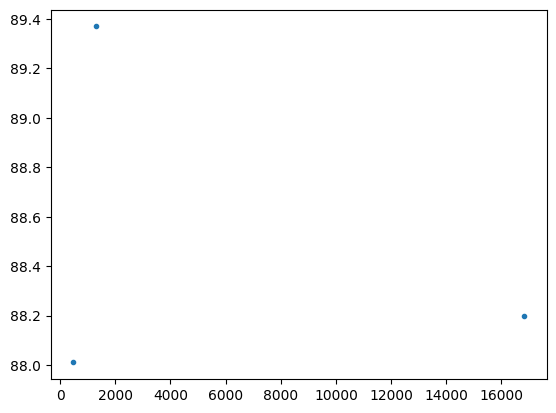

In [67]:
plt.plot(df_clean["pl_orbincl"], '.')

In [68]:
# sort the DataFrame by the hostname
df_clean = df_clean.sort_values(by="hostname")

In [69]:
maxmass_plnames = []

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # take the planet with maximum mass
    maxmass_pl = df_host["pl_bmasse"].idxmax()
    maxmass_plnames.append(hostname)

    # # if the obliquity is null, do this:
    # if df_host["pl_trueobliq"].isnull().all():

    df_clean.loc[df_host.index, "pl_relincl"] = \
        df_host.loc[maxmass_pl, "pl_orbincl"] - df_host["pl_orbincl"]
    
    df_clean.loc[df_host.index, "pl_relinclerr1"] = \
        np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr1"]**2 + df_host["pl_orbinclerr1"]**2)
    
    df_clean.loc[df_host.index, "pl_relinclerr2"] = \
        np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr2"]**2 + df_host["pl_orbinclerr2"]**2)
    # elif df_host["pl_trueobliq"].notnull().all():
    #     # assume the relative inclination is equal to the true obliquity

    #     df_clean.loc[df_host.index, "pl_relincl"] = df_host["pl_trueobliq"]
    #     df_clean.loc[df_host.index, "pl_relinclerr1"] = df_host["pl_trueobliqerr1"]
    #     df_clean.loc[df_host.index, "pl_relinclerr2"] = df_host["pl_trueobliqerr2"]

    # else:
    #     raise ValueError("There is a mix of NaN and non-NaN values in the obliquity column")

In [70]:
df_clean = df_clean.drop(479)

In [71]:
df_clean

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2
1312,K2-290 c,K2-290,1.0,0.3050,0.017,-0.017,246.000420,14.93801,-14.93801,2.0,...,89.37,0.08,-0.07,124.0,6.0,-6.0,01+1-,0.00,0.113137,0.098995
16822,K2-290 b,K2-290,1.0,0.0923,0.000,0.000,10.904186,0.00000,0.00000,2.0,...,88.20,0.50,-0.60,127.0,0.0,0.0,0,1.17,0.506360,0.604070


In [72]:
def amd(m: np.array, e: np.array, i: np.array, a: np.array) -> np.array:
    return m * np.sqrt(a) * (1 - np.sqrt(1 - e**2) * np.cos(np.deg2rad(i)))

def namd(amd: np.array, m: np.array, a: np.array) -> float:
    return np.sum(amd) / np.sum(m * np.sqrt(a))

In [73]:
for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # calculate the AMD
    amd_val = amd(
        df_host["pl_bmasse"], 
        df_host["pl_orbeccen"], 
        df_host["pl_relincl"], 
        df_host["pl_orbsmax"])
    
    df_clean.loc[df_host.index, "amd"] = amd_val

    # calculate the NAMD
    namd_val = namd(amd_val, df_host["pl_bmasse"], df_host["pl_orbsmax"])

    df_clean.loc[df_host.index, "namd"] = namd_val

In [77]:
df_clean

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2,amd,namd
1312,K2-290 c,K2-290,1.0,0.3050,0.017,-0.017,246.000420,14.93801,-14.93801,2.0,...,-0.07,124.0,6.0,-6.0,01+1-,0.00,0.113137,0.098995,0.000000,0.000005
16822,K2-290 b,K2-290,1.0,0.0923,0.000,0.000,10.904186,0.00000,0.00000,2.0,...,-0.60,127.0,0.0,0.0,0,1.17,0.506360,0.604070,0.000691,0.000005


In [75]:
np.log10(df_clean["namd"]) # this is assuming the relincl

1312    -5.304273
16822   -5.304273
Name: namd, dtype: float64

In [76]:
np.log10(1.560207)

0.1931822220684561

In [53]:
df_clean # this is assuming the obliquity

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2,amd,namd
1312,K2-290 c,K2-290,1.0,0.3050,0.017,-0.017,246.000420,14.93801,-14.93801,2.0,...,-0.07,124.0,6.0,-6.0,01+1-,124.0,6.0,-6.0,211.829098,1.560207
16822,K2-290 b,K2-290,1.0,0.0923,0.000,0.000,10.904186,0.00000,0.00000,2.0,...,-0.60,127.0,0.0,0.0,0,127.0,0.0,0.0,5.306479,1.560207


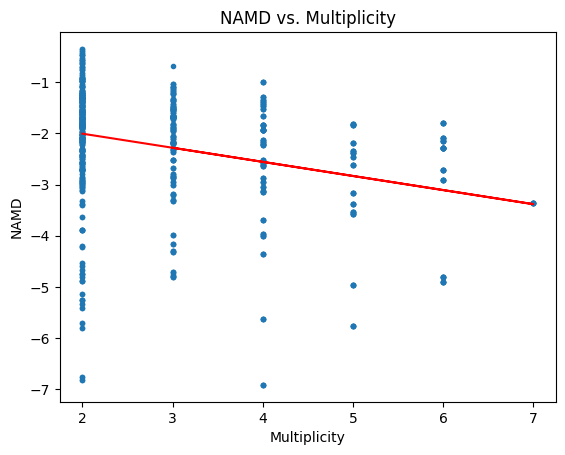

Slope: -0.28, Intercept: -1.45


In [199]:
plt.figure()
idx = df_clean["namd"].values > 0
plt.plot(df_clean["sy_pnum"], np.log10(df_clean["namd"]), '.')
coeffs = np.polyfit(df_clean["sy_pnum"][idx], np.log10(df_clean["namd"][idx]), 1)
plt.plot(df_clean["sy_pnum"], np.polyval(coeffs, df_clean["sy_pnum"]), 'r')
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.title("NAMD vs. Multiplicity")
plt.xticks(range(2, 8))
plt.show()

print(f"Slope: {coeffs[0]:.2f}, Intercept: {coeffs[1]:.2f}")

In [187]:
df_clean.hostname.unique()

array(['24 Sex', '47 UMa', '55 Cnc', '61 Vir', '7 CMa', '75 Cet',
       'BD-06 1339', 'BD-08 2823', 'BD-11 4672', 'BD-210397', 'CoRoT-20',
       'CoRoT-24', 'DMPP-1', 'EPIC 212737443', 'EPIC 220674823',
       'EPIC 249893012', 'G 264-012', 'GJ 1002', 'GJ 1061', 'GJ 1132',
       'GJ 1148', 'GJ 15 A', 'GJ 163', 'GJ 180', 'GJ 2030', 'GJ 229',
       'GJ 273', 'GJ 3138', 'GJ 317', 'GJ 328', 'GJ 3293', 'GJ 3323',
       'GJ 3473', 'GJ 3512', 'GJ 357', 'GJ 3929', 'GJ 3998', 'GJ 414 A',
       'GJ 433', 'GJ 581', 'GJ 667 C', 'GJ 676 A', 'GJ 682', 'GJ 687',
       'GJ 806', 'GJ 849', 'GJ 876', 'GJ 887', 'GJ 9827', 'HAT-P-11',
       'HAT-P-13', 'HAT-P-17', 'HAT-P-44', 'HATS-59', 'HD 10180',
       'HD 104067', 'HD 105618', 'HD 106315', 'HD 107148', 'HD 108236',
       'HD 108874', 'HD 109271', 'HD 110067', 'HD 110113', 'HD 111232',
       'HD 113337', 'HD 113538', 'HD 114783', 'HD 11506', 'HD 115404 A',
       'HD 11964', 'HD 12235', 'HD 125612', 'HD 12661', 'HD 128311',
       'HD 133131 

In [188]:
def compute_namd(userid: str, df: pd.DataFrame, Npt: int, do_plot: bool = True, seed: int = 42):

    np.random.seed(seed)

    user_df = df[df["hostname"] == userid]

    pl_df_mcmc_samples = pd.DataFrame(columns=np.array([[f"pl_bmasse_{pl_name}", f"pl_orbsmax_{pl_name}", f"pl_orbeccen_{pl_name}", f"pl_relincl_{pl_name}"] for pl_name in user_df["pl_name"]]).flatten(), index=range(Npt))

    for pl_name in user_df["pl_name"]:
        pl_df = user_df[user_df["pl_name"] == pl_name]
        
        pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_bmasse"],
            scale=0.5 * (pl_df["pl_bmasseerr1"]-pl_df["pl_bmasseerr2"]),
            size=Npt)
        
        pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_orbsmax"],
            scale=0.5 * (pl_df["pl_orbsmaxerr1"]-pl_df["pl_orbsmaxerr2"]),
            size=Npt)

        pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_orbeccen"],
            scale=0.5 * (pl_df["pl_orbeccenerr1"]-pl_df["pl_orbeccenerr2"]),
            size=Npt)

        pl_df_mcmc_samples[f"pl_relincl_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_relincl"],
            scale=0.5 * (pl_df["pl_orbinclerr1"]-pl_df["pl_orbinclerr2"]),
            size=Npt)

        pl_df_mcmc_samples[f"good_idx_{pl_name}"] = (
            (pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"] >= 0) & (pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"] <= 1) &
            (pl_df_mcmc_samples[f"pl_relincl_{pl_name}"] >= 0) & (pl_df_mcmc_samples[f"pl_relincl_{pl_name}"] <= 180) &
            (pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"] >= 0) &
            (pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"] >= 0)
            )
        
        pl_df_mcmc_samples[f"amd_{pl_name}"] = amd(
            pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"], 
            pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"], 
            pl_df_mcmc_samples[f"pl_relincl_{pl_name}"], 
            pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"])
        
    # keep rows of pl_df_mcmc_samples where good_idx is True for all planets
    pl_df_mcmc_samples = pl_df_mcmc_samples[pl_df_mcmc_samples.filter(like="good_idx").all(axis=1)]

    # for each row, sum the AMDs of all planets and store the result in a new column called "namd_num"
    pl_df_mcmc_samples["namd_num"] = pl_df_mcmc_samples.filter(like="amd").sum(axis=1)

    # for each row, compute the sum of: (mass of each planet * sqrt(semi-major axis of each planet))
    pl_df_mcmc_samples["namd_den"] = np.sum([pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"] * np.sqrt(pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"]) for pl_name in user_df["pl_name"]], axis=0)

    # compute the NAMD
    pl_df_mcmc_samples["namd"] = pl_df_mcmc_samples["namd_num"] / pl_df_mcmc_samples["namd_den"]

    if len(pl_df_mcmc_samples) < Npt // 20:

        return {"q16": np.nan, "q50": np.nan, "q84": np.nan, "N": user_df["sy_pnum"].values[0]}

    quantiles = pl_df_mcmc_samples["namd"].quantile([0.16, 0.5, 0.84])
    if do_plot:
        print("Plotting...")
        plt.figure()
        # plt.hist(pl_df_mcmc_samples["namd"], bins=50)
        # use log-spaced bins instead of linear-spaced bins
        plt.hist(pl_df_mcmc_samples["namd"], bins=np.logspace(np.log10(pl_df_mcmc_samples["namd"].min()), np.log10(pl_df_mcmc_samples["namd"].max()), 50))
        plt.vlines(quantiles, 0, plt.ylim()[1], color=["red", "black", "red"], linestyles="dashed")
        plt.xscale("log")
        plt.xlabel("NAMD")
        plt.ylabel("Frequency")
        title = f"{userid}: " + f"NAMD = ${quantiles[0.5]:.2f}^{{+{quantiles[0.84]-quantiles[0.5]:.2f}}}_{{-{quantiles[0.5]-quantiles[0.16]:.2f}}}$"
        plt.title(title)
        plt.show()

    return {"q16": quantiles[0.16], "q50": quantiles[0.5], "q84": quantiles[0.84], "N": user_df["sy_pnum"].values[0]}

Plotting...


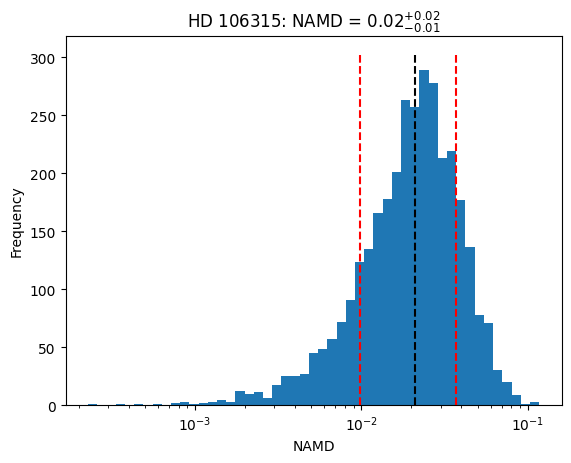

In [211]:
userid = "HD 106315"
Npt = 10000

res = compute_namd(userid, df_clean, Npt, do_plot=True)

In [216]:
df_clean[df_clean["hostname"] == userid]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2,amd,namd
1606,HD 106315 b,HD 106315,1,0.09031,0.000915,-0.000965,12.6,3.2,-3.2,2,...,-0.068,88.01,1.0915,-1.27,0,0.6,1.162485,1.294372,0.077870,0.018
4721,HD 106315 c,HD 106315,1,0.15295,0.001550,-0.001600,14.9,4.2,-4.2,2,...,-0.101,88.61,0.4000,-0.25,0,0.0,0.565685,0.353553,0.095178,0.018


In [245]:
def select_flag(df: pd.DataFrame, flag_list: list, do_plot: bool = True):

    flag_indices = []

    for hostname in df_clean["hostname"].unique():
        # if all the planets in the system have flag=0, we store the index
        df_host = df_clean[df_clean["hostname"] == hostname]
        flags = df_host["flag"].unique()
        if len(flags) == 1:
            if flags in flag_list:
                flag_indices.extend(df_host.index)

    # print(len(flag_indices))
    print(f"Number of systems with flag {flag_list}: {len(flag_indices)}")

    df_clean_flag = df_clean.loc[flag_indices]

    idx = df_clean_flag["namd"].values > 0
    coeffs = np.polyfit(df_clean_flag["sy_pnum"][idx], np.log10(df_clean_flag["namd"][idx]), 1)
    print(f"Slope: {coeffs[0]:.2f}, Intercept: {coeffs[1]:.2f}")

    if do_plot:
        plt.figure()
        plt.plot(df_clean_flag["sy_pnum"], np.log10(df_clean_flag["namd"]), '.')
        plt.plot(df_clean_flag["sy_pnum"], np.polyval(coeffs, df_clean_flag["sy_pnum"]), 'r')
        plt.xlabel("Multiplicity")
        plt.ylabel("NAMD")
        plt.title(f"NAMD vs. Multiplicity for flag {flag_list}")
        plt.xticks(range(2, 8))
        plt.show()

    return


Number of systems with flag ['03']: 256
Slope: -0.11, Intercept: -1.63


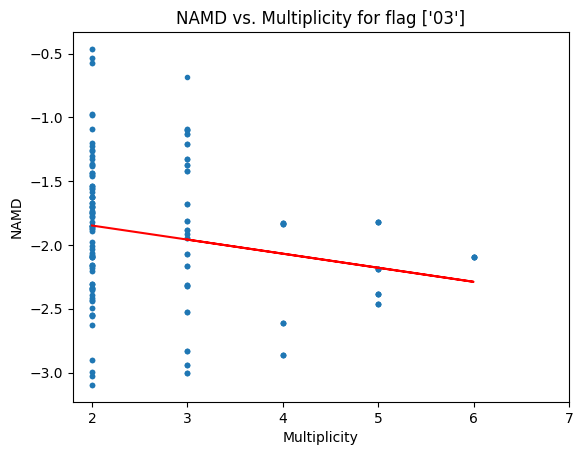

Number of systems with flag ['0']: 144
Slope: -0.27, Intercept: -1.92


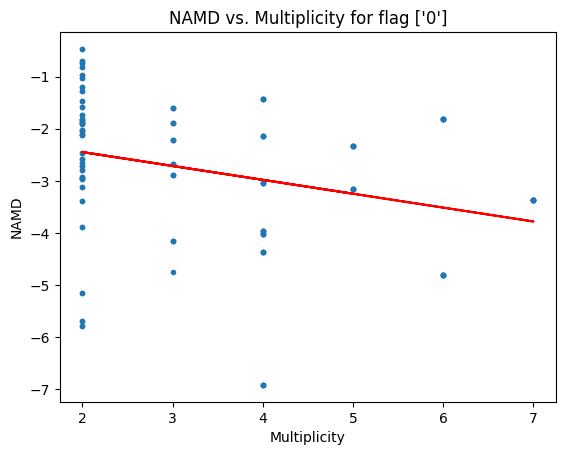

In [246]:
for flag_name in df_clean["flag"].unique()[:2]:
    select_flag(df_clean, [flag_name], do_plot=True)

Number of systems with flag ['0', '03']: 400
Slope: -0.26, Intercept: -1.47


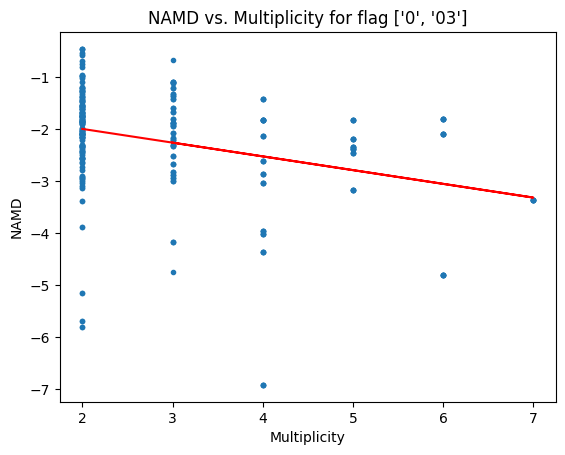

In [247]:
select_flag(df_clean, ["0", "03"], do_plot=True)

In [236]:
df_clean["flag"].unique()

array(['03', '0', '03+3-', '01+1-3', '01+1-', '01+1-2+2-', '02', '013',
       '01', '012+2-', '033+3-', '01+1-2', '01+1-3+3-', '012', '02+2-',
       '0123', '023+3-', '01+1-23+3-'], dtype=object)

In [212]:
res

{'q16': 0.00989833322097687,
 'q50': 0.020967120400305673,
 'q84': 0.03719319175181066,
 'N': 2}

In [213]:
(res["q84"] - res["q50"])/res["q50"], (res["q50"] - res["q16"])/res["q50"]

(0.7738817272813693, 0.5279116525303796)

In [192]:
results = {}
nsy = len(df_clean.hostname.unique())
q50 = np.zeros(nsy)
multiplicity = np.zeros(nsy)

for k, name in enumerate(df_clean.hostname.unique()):
    results[name] = compute_namd(name, df_clean, Npt=int(1e5), do_plot=False)
    q50[k] = results[name]["q50"]
    multiplicity[k] = results[name]["N"]
    # if multiplicity[k] == 5:
    #     print(name, results[name])

q50nan_index = np.isnan(q50) | (q50 == 0)
multiplicity = multiplicity[~q50nan_index]
q50 = q50[~q50nan_index]

55 Cnc {'q16': nan, 'q50': nan, 'q84': nan, 'N': 5}
GJ 667 C {'q16': 0.008200018236942384, 'q50': 0.017374314926611758, 'q84': 0.040234696527278874, 'N': 5}
HD 108236 {'q16': 0.01580603980989568, 'q50': 0.03474291616110764, 'q84': 0.06825757580304899, 'N': 5}
HD 134606 {'q16': 0.0020306123771926896, 'q50': 0.00466547521996351, 'q84': 0.008933564511810321, 'N': 5}
HD 20781 {'q16': 0.0025940580049261175, 'q50': 0.004891708544040902, 'q84': 0.008216320458500714, 'N': 5}
HD 23472 {'q16': nan, 'q50': nan, 'q84': nan, 'N': 5}
HD 40307 {'q16': 0.007020609550212188, 'q50': 0.01919060097394204, 'q84': 0.04954535062022365, 'N': 5}
Kepler-102 {'q16': nan, 'q50': nan, 'q84': nan, 'N': 5}
Kepler-186 {'q16': nan, 'q50': nan, 'q84': nan, 'N': 5}
Kepler-296 {'q16': nan, 'q50': nan, 'q84': nan, 'N': 5}
Kepler-32 {'q16': 0.00020533548728338257, 'q50': 0.0002695590266908437, 'q84': 0.0003341070764414169, 'N': 5}
Kepler-33 {'q16': nan, 'q50': nan, 'q84': nan, 'N': 5}
Kepler-62 {'q16': 1.2787984378056769e-

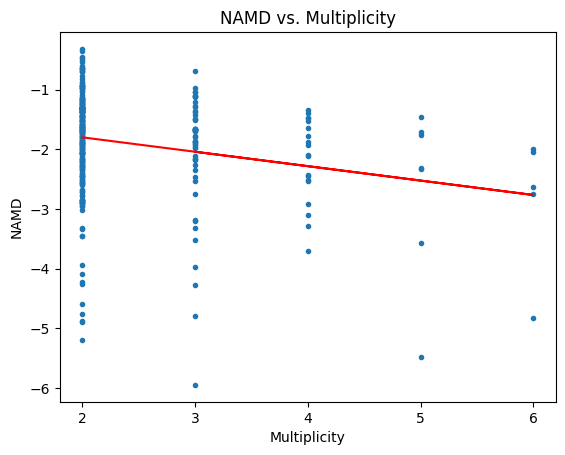

Slope: -0.24, Intercept: -1.32


In [193]:
plt.figure()
plt.plot(multiplicity, np.log10(q50), '.')
coeffs = np.polyfit(multiplicity, np.log10(q50), 1)
plt.plot(multiplicity, np.polyval(coeffs, multiplicity), 'r')
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.title("NAMD vs. Multiplicity")
plt.xticks(range(2, 7))
plt.show()

print(f"Slope: {coeffs[0]:.2f}, Intercept: {coeffs[1]:.2f}")